In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['figure.dpi'] = 80
# matplotlib.rcParams['figure.figsize'] = [17, 4]
matplotlib.rcParams['axes.grid'] = True

In [2]:
# !pip install --upgrade pip --proxy=https://web-proxy.labs.hpecorp.net:8088
import sys
sys.version_info

sys.version_info(major=3, minor=7, micro=4, releaselevel='final', serial=0)

In [3]:
import sys
sys.path.insert(0, '../')

from lib_data import *
from lib_nn_dpe import NN_dpe

In [4]:
load_workspace(vars(), 'data/20190821-051552-mnist_xs')
load_workspace(vars(), 'data/20200130-100802-mnist_config')

Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, xs, acc, result, x1, 
Loaded: xs, new_lin_cor_fc1, new_lin_cor_fc2, lin_cor_conv, finalGfc, finalGconv, weights, 


In [5]:
del train_images
del train_labels
# del test_images
# del test_labels
del xs

In [6]:
from lib_ecc import *

## Construct NN

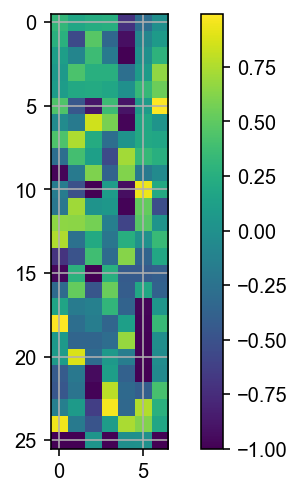

In [7]:
nn = NN_dpe(weights)

nn.Gratio = 100e-6

plt.imshow(nn.Mconv); plt.colorbar()

In [8]:
nn.Gratio

0.0001

## ECC matrix

7 4.0 7.0
The number of redundancy column is chosen to be the smallest even number 8
(26, 15)


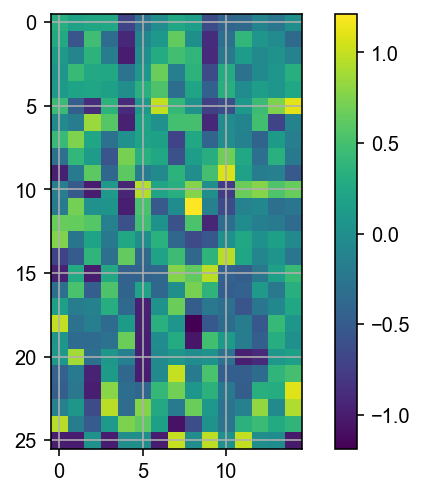

In [9]:
from dpeECC import dpeECC

delta = 1
Delta = 8 * delta

m = nn.Mconv.shape[0]
k = nn.Mconv.shape[1]

print(k, np.ceil(np.sqrt(k+1))+1, 2*k/(np.floor(Delta/(2*delta))-2))

ecc = dpeECC(nn.Mconv, delta, Delta)
M_conv_ecc = ecc.encode()

print('The number of redundancy column is chosen to be the smallest even number', ecc.r)
print(M_conv_ecc.shape)

plt.imshow(M_conv_ecc); plt.colorbar()

Convert to conductance

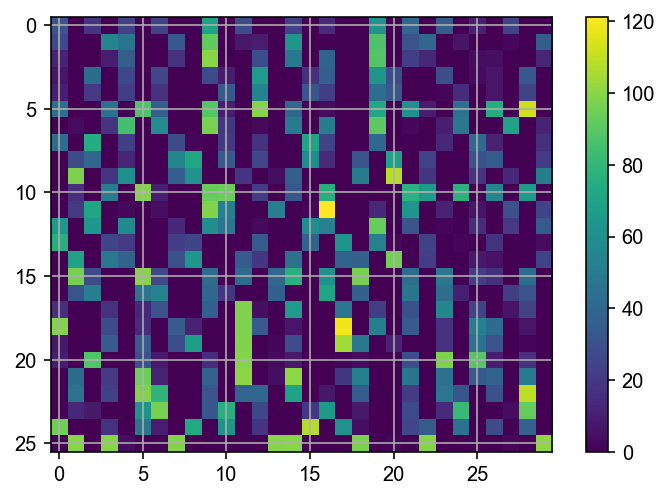

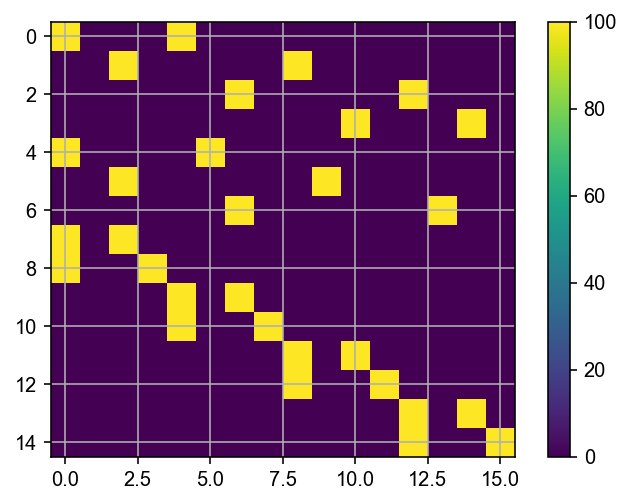

In [10]:
G_conv_ecc = weight2conductance(M_conv_ecc)
G_parity_ecc = weight2conductance(ecc.H.T)

plt.figure(1)
plt.imshow(G_conv_ecc * 1e6); plt.colorbar()

plt.figure(2)
plt.imshow(G_parity_ecc * 1e6); plt.colorbar()

## Program the array

In [11]:
from dpe import DPE

dpe = DPE('COM9')
dpe.set_clock(50)

DAC initialized to a span from -10 V to 10 V
Setting vrefs to default
Setting ADC_CK freq=50000.0kHz
Setting CK_ARRAY freq=50000.0kHz


....

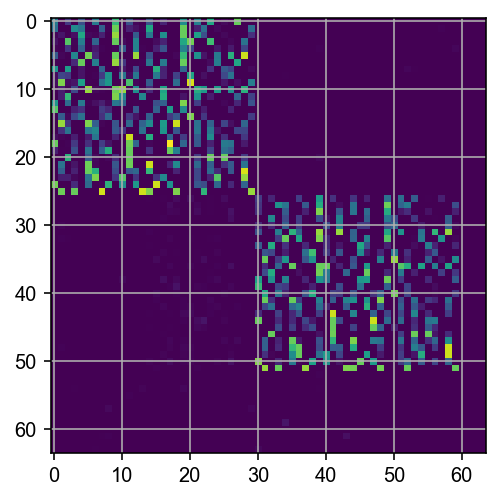

In [12]:
g = dpe.read(1, method='slow')
plt.imshow(g)

In [13]:
Gtarget = np.zeros((64,64))

rs = 0
cs = 0

Gtarget[rs:rs+G_conv_ecc.shape[0], cs:cs+G_conv_ecc.shape[1]] = G_conv_ecc

Gtarget[rs+G_conv_ecc.shape[0]: rs+G_conv_ecc.shape[0]*2, 
        cs+G_conv_ecc.shape[1]: cs+G_conv_ecc.shape[1]*2] = G_conv_ecc

Msel = np.ones((64,64))
# Msel[20:,20:] = 1
# Msel[Gtarget<4e-6] = 0

# Msel = np.zeros((64,64))
# Msel[rs:rs+G_conv_ecc.shape[0], cs:cs+G_conv_ecc.shape[1]] = 1
# Msel[rs+G_conv_ecc.shape[0]: rs+G_conv_ecc.shape[0]*2, 
#         cs+G_conv_ecc.shape[1]: cs+G_conv_ecc.shape[1]*2] = 1

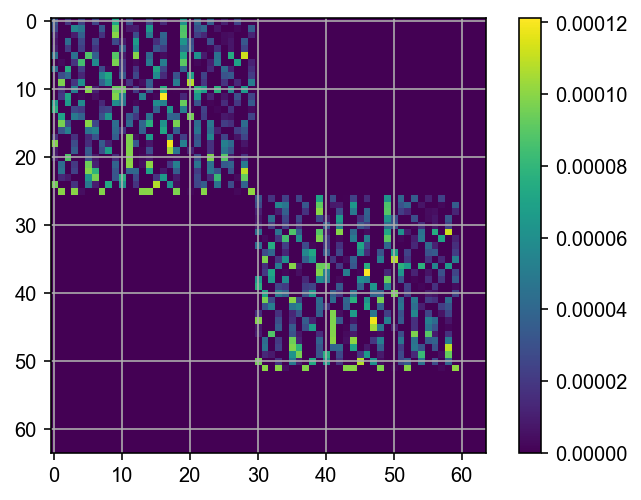

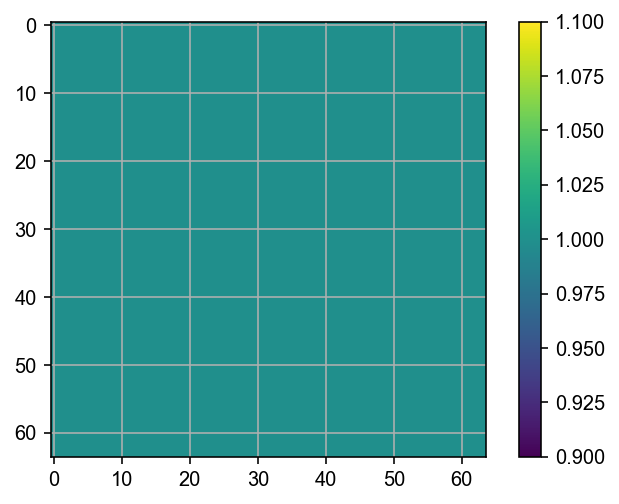

In [14]:
plt.imshow(Gtarget)
plt.colorbar()

plt.figure()
plt.imshow(Msel)
plt.colorbar()

In [15]:
data = dpe.tune_conductance(1,  Gtarget, saveHistory=True, maxSteps=1000, method='slow',
                           vSetRamp=[1, 3, 0.25], vGateSetRamp=[0.5, 1.4, 0.05],
                           vResetRamp=[0.3, 1.5, 0.05], vGateResetRamp=[5.0, 5.5, 0.5], 
                           Twidth=10e-6, TwidthReset=1e-3,  Msel=Msel, Gtol_in=4e-6, Gtol_out=10e-6, numReads=1)

Start programming, step=0, maxBound=0 yield= 88.26% - 95.51%
481.0 devices to be programmed...reset 128.0, set 353.0
Setting 353 devices...
Programming with external timing Twidth=10.000 us
Resetting 128 devices...
Programming with external timing Twidth=1000.000 us
..

KeyboardInterrupt: 

....

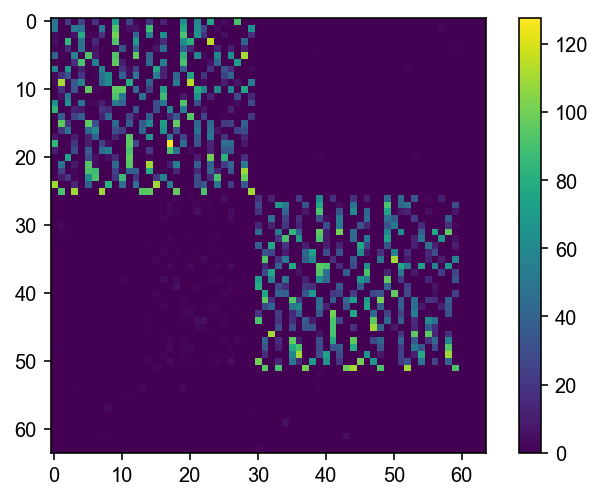

In [18]:
g = dpe.read(1, method='slow')
plt.imshow(g2*1e6); plt.colorbar()
plt.grid(False)

In [96]:
# g2 = dpe.read(1, method='slow')

# plt.imshow(g2)
# # plt.imshow(g2[rs:rs+G_conv_ecc.shape[0], cs:cs+G_conv_ecc.shape[1]]*1e6); plt.colorbar()
# plt.grid(False)
# plt.colorbar()

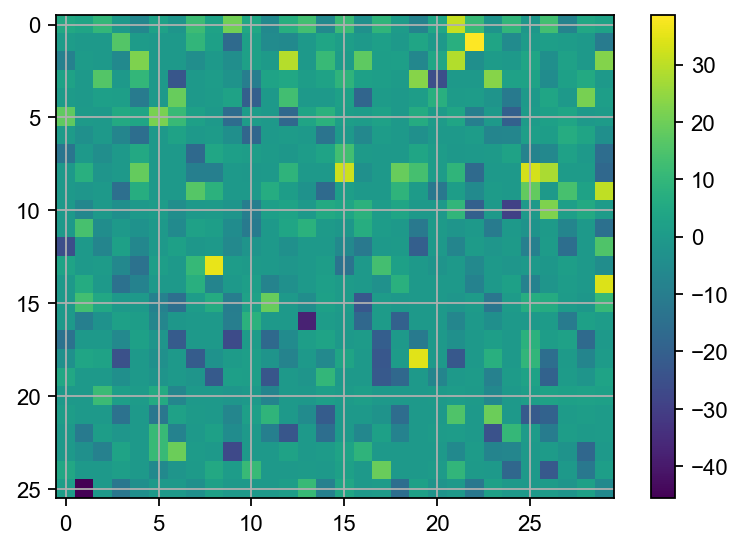

In [155]:
plt.imshow((g2-Gtarget)[rs:rs+G_conv_ecc.shape[0], cs:cs+G_conv_ecc.shape[1]]* 1e6 )
plt.colorbar()

In [63]:
data = dpe.tune_conductance(1,  Gtarget, saveHistory=True, maxSteps=300, method='slow',
                           vSetRamp=[1, 3, 0.25], vGateSetRamp=[0.5, 1.4, 0.05],
                           vResetRamp=[0.3, 2.2, 0.05], vGateResetRamp=[5.0, 5.5, 0.5], 
                           Twidth=10e-6, TwidthReset=10e-3,  Msel=Msel, Gtol_in=50e-6, Gtol_out=110e-6, numReads=1)

Start programming, step=11, maxBound=0 yield= 99.68% - 100.00%
6.0 devices to be programmed...reset 5.0, set 1.0
Setting 1 devices...
Programming with external timing Twidth=10.000 us
Resetting 5 devices...
Programming with external timing Twidth=10000.000 us


KeyboardInterrupt: 

In [195]:
Msel = np.zeros((64,64))
Msel[20:,20:] = 1

Text(0, 0.5, 'Count')

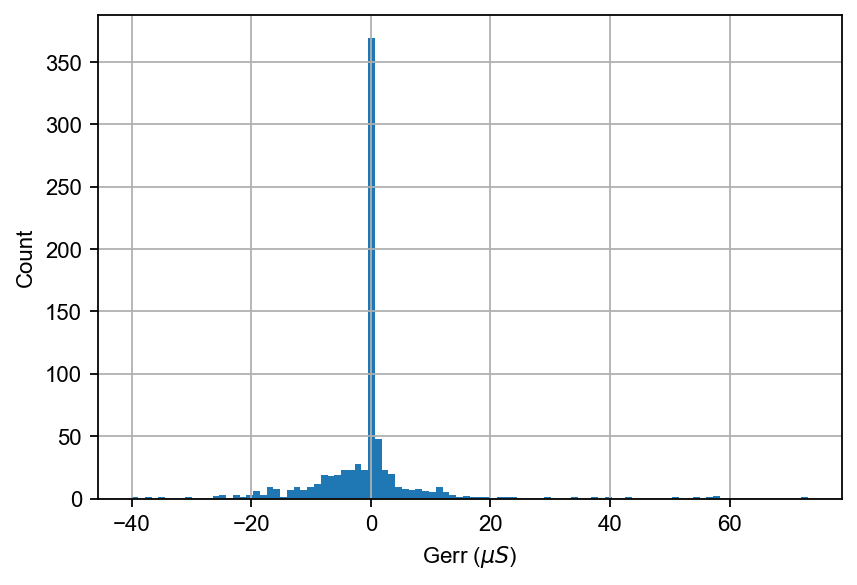

In [31]:
gdiff = (g2-Gtarget)[rs:rs+G_conv_ecc.shape[0], cs:cs+G_conv_ecc.shape[1]]* 1e6 

_ = plt.hist((gdiff.reshape(-1)), 100)

plt.xlabel('Gerr ($\mu S$)')
plt.ylabel('Count')

# plt.xlim((-30, 30))

## CNN test

In [16]:
rs = G_conv_ecc.shape[0]
cs = G_conv_ecc.shape[1]

i = 0

N_IMG = 10

vectors_list = []
output_list = []

for img, lab in tqdm(zip(test_images, test_labels), total=N_IMG):
    i += 1

    vectors = nn._conv_flattern(img)
    output = dpe.multiply(
            1, 
            vectors, 
            c_sel=[cs, cs+G_conv_ecc.shape[1]], 
            r_start=rs, mode=0, Tdly=500) / (nn.Gratio)
#             c_sel=[0, 0+G_conv_ecc.shape[1]], 
#             r_start=0, mode=0, Tdly=500) / (nn.Gratio)
    
    vectors_list.append(vectors)
    output_list.append(output)
    
    if i >= N_IMG:
        break

In [17]:
vectors = np.concatenate(vectors_list, axis=1)
output = np.concatenate(output_list, axis=0)

In [18]:
output_soft = vectors.T @ G_conv_ecc / nn.Gratio

(4000, 30) (4000, 30)


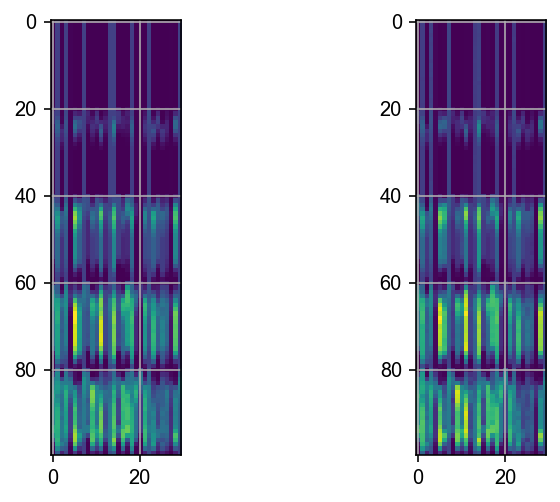

In [19]:
plt.subplot(121)
plt.imshow(output_soft[:100])

plt.subplot(122)
plt.imshow(output[:100])

print(output.shape, output_soft.shape)

Core output

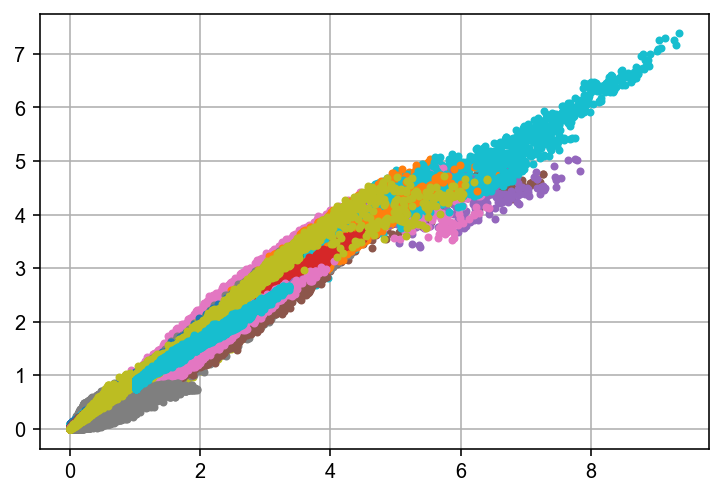

In [20]:
for c in range(output.shape[1]):
    plt.plot(output_soft[:,c], output[:,c], '.')

Linear correction

In [21]:
lin_cor_conv = []
for c in range(output.shape[1]):
    lin_cor_conv.append( np.polyfit(output[:,c], output_soft[:,c], 1))
    
output_cor = dpe.lin_corr(output, lin_cor_conv)

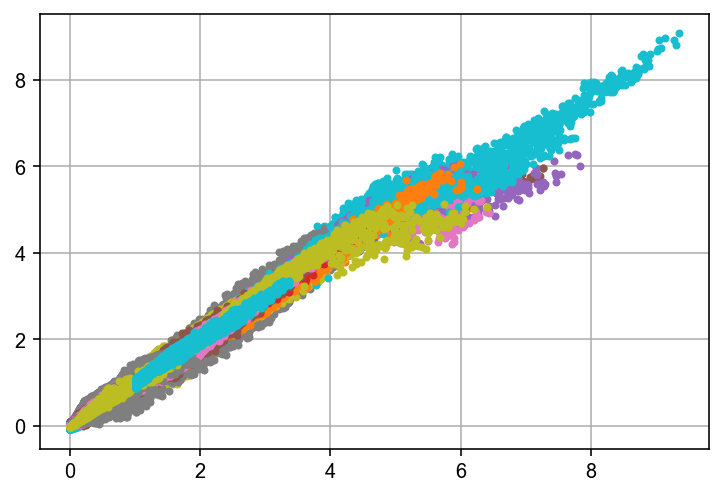

In [22]:
for c in range(output.shape[1]):
    plt.plot(output_soft[:,c], output_cor[:,c], '.')

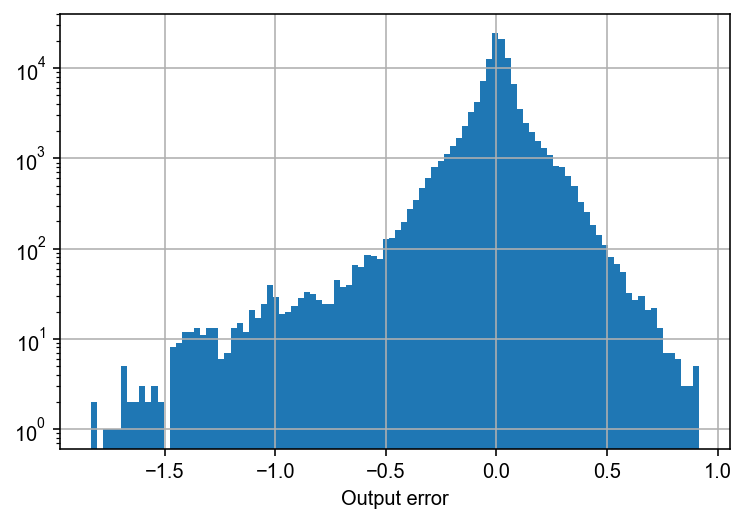

In [23]:
_ = plt.hist((output_cor - output_soft ).reshape(-1), 100)
plt.xlabel('Output error')

plt.yscale('log')

In [24]:
# save_workspace(vars(), note='programming1', skip_mat=True)

# CNN test fixed gain

In [25]:
rs = G_conv_ecc.shape[0]
cs = G_conv_ecc.shape[1]

i = 0

N_IMG = 10

vectors_list = []
output_list = []

for img, lab in tqdm(zip(test_images, test_labels), total=N_IMG):
    i += 1

    vectors = nn._conv_flattern(img)
    output = dpe.multiply(
            1, 
            vectors, 
            c_sel=[cs, cs+G_conv_ecc.shape[1]], 
            r_start=rs, mode=0, Tdly=500, gain=1) / (nn.Gratio)
#             c_sel=[0, 0+G_conv_ecc.shape[1]], 
#             r_start=0, mode=0, Tdly=500) / (nn.Gratio)
    
    vectors_list.append(vectors)
    output_list.append(output)
    
    if i >= N_IMG:
        break
        
vectors = np.concatenate(vectors_list, axis=1)
output = np.concatenate(output_list, axis=0)

(4000, 30) (4000, 30)


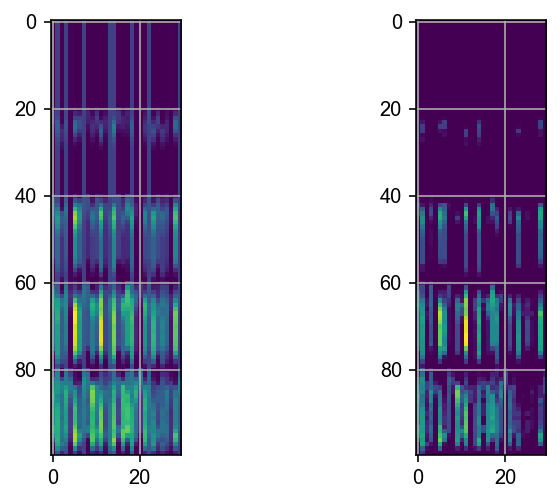

In [26]:
output_soft = vectors.T @ G_conv_ecc / nn.Gratio

plt.subplot(121)
plt.imshow(output_soft[:100])

plt.subplot(122)
plt.imshow(output[:100])

print(output.shape, output_soft.shape)

In [27]:
output.shape, output_soft.shape

((4000, 30), (4000, 30))

Text(0.5, 0, 'Expected output')

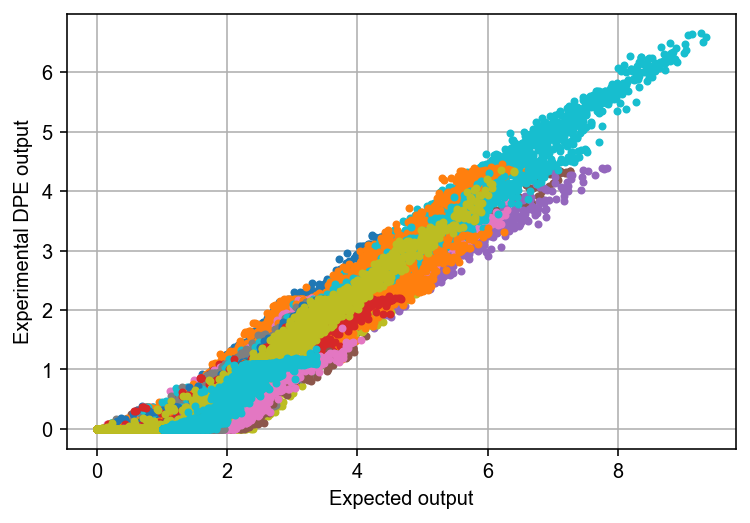

In [28]:
for c in range(output.shape[1]):
    plt.plot(output_soft[:,c], output[:,c], '.')
    
plt.ylabel('Experimental DPE output')
plt.xlabel('Expected output')

In [29]:
lin_cor_conv = []
for c in range(output.shape[1]):
    lin_cor_conv.append( np.polyfit(output[:,c], output_soft[:,c], 1))
    
output_cor = dpe.lin_corr(output, lin_cor_conv)

c:\users\localuser\.venvs\py37\lib\site-packages\numpy\lib\polynomial.py:630: RuntimeWarning: invalid value encountered in true_divide
  lhs /= scale


LinAlgError: SVD did not converge in Linear Least Squares

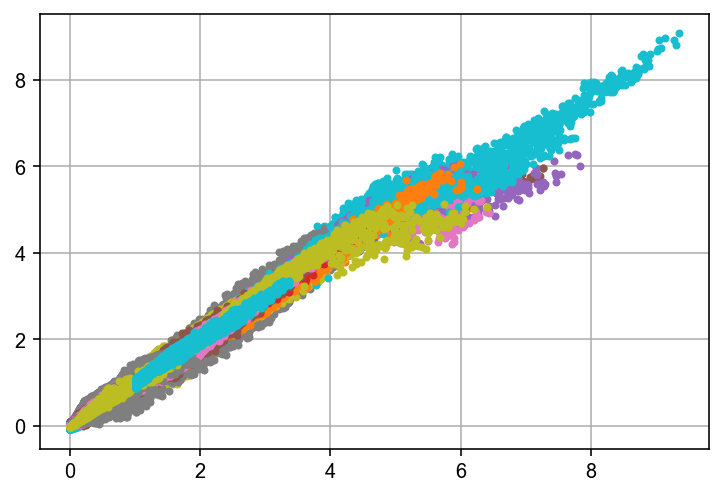

In [30]:
for c in range(output.shape[1]):
    plt.plot(output_soft[:,c], output_cor[:,c], '.')

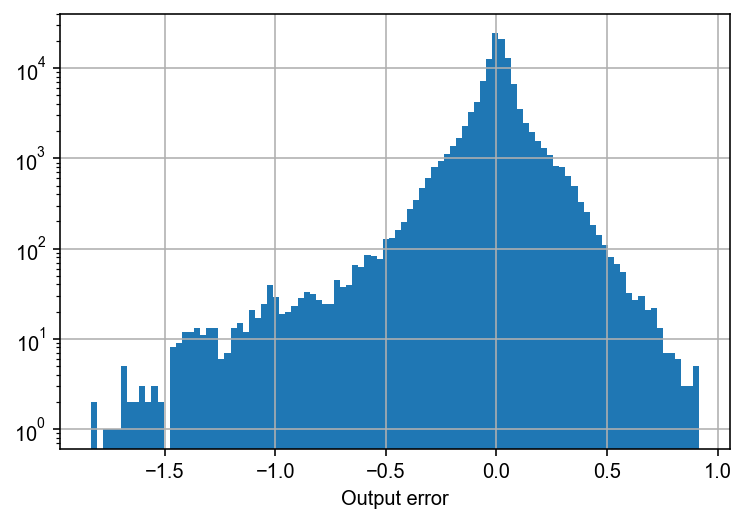

In [31]:
_ = plt.hist((output_cor - output_soft ).reshape(-1), 100)
plt.xlabel('Output error')

plt.yscale('log')

## Linear correction for different gains

In [38]:
rs = G_conv_ecc.shape[0]
cs = G_conv_ecc.shape[1]

i = 0

N_IMG = 10

gain_list = [1,2, 3]

output_gain = []

for gain in tqdm(gain_list):
    vectors_list = []
    output_list = []

    for img, lab in tqdm(zip(test_images[:N_IMG], test_labels[:N_IMG]), total=N_IMG):
        i += 1

        vectors = nn._conv_flattern(img)
        output = dpe.multiply(
                1, 
                vectors, 
                c_sel=[cs, cs+G_conv_ecc.shape[1]], 
                r_start=rs, mode=0, Tdly=500, gain=gain
        ) / (nn.Gratio)

        vectors_list.append(vectors)
        output_list.append(output)

    #     if i >= N_IMG:
    #         break

    vectors = np.concatenate(vectors_list, axis=1)
    output = np.concatenate(output_list, axis=0)
    
    output_gain.append(output.copy())

In [41]:
gain_th = [
    5.82*30,
    5.82*6,
    5.82, #verified
    0.875,
    0.175
]

gain_value = np.zeros_like(output_soft)

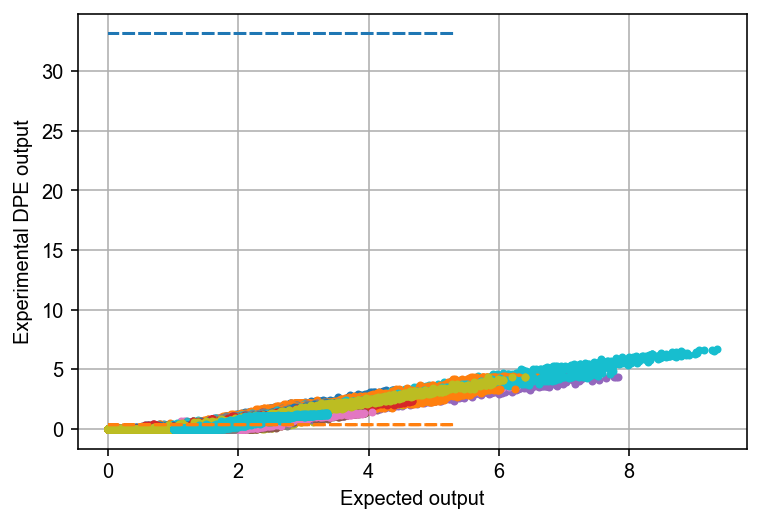

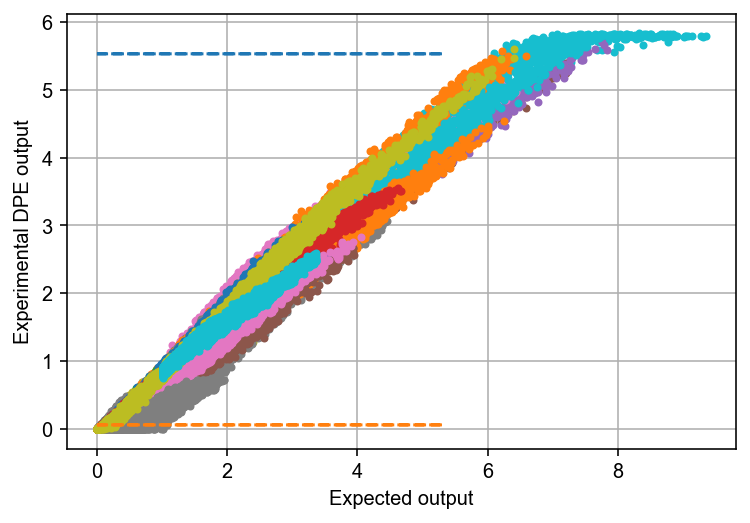

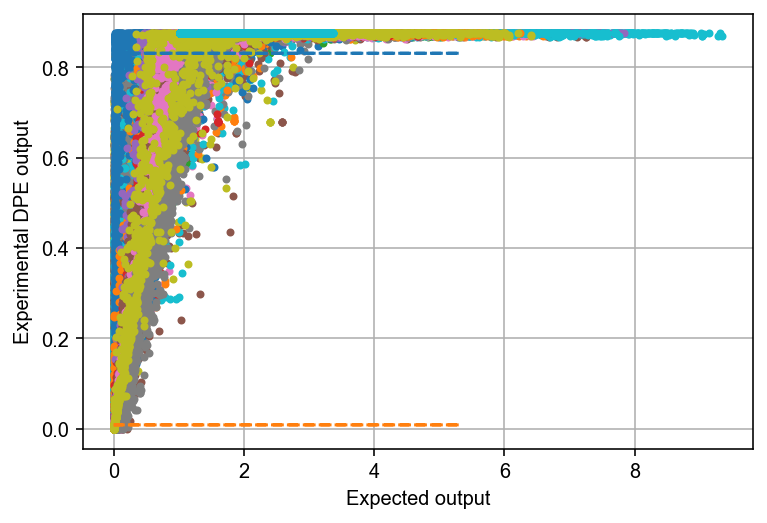

In [42]:
output_soft = vectors.T @ G_conv_ecc / nn.Gratio

for i, gain in enumerate(gain_list):
    
    plt.figure(i+1)
    for c in range(output_gain[i].shape[1]):
        plt.plot(output_soft[:,c], output_gain[i][:,c], '.')
        
        
    gain_value[:,0] = gain_th[gain]
    plt.plot(output_soft[:,0], gain_value[:,0]* 0.95, '--')
    plt.plot(output_soft[:,0], gain_value[:,0]* 0.01, '--')
    
    plt.ylabel('Experimental DPE output')
    plt.xlabel('Expected output')

## Fitting

In [43]:
lin_cor_gain = []

th_rel = [0.9, 0.02]

for i, output in enumerate(output_gain):
    output = output.copy()
    
    gain = gain_list[i]
    print(i, gain, gain_th[gain])
    
    output[output > gain_th[gain] * th_rel[0]] = np.nan
    output[output < gain_th[gain] * th_rel[1]] = np.nan
    
#     plt.figure(i+1)
#     for c in range(output_gain[i].shape[1]):
#         plt.plot(output_soft[:,c], output[:,c], '.')
        
    lin_cor = []
    for c in range(output.shape[1]):
        
        idx = np.isfinite(output[:,c]) & np.isfinite(output_soft[:,c])
        if sum(idx) > 0:
            lin_cor.append( np.polyfit(output[idx,c], output_soft[idx,c], 1))
        else:
            lin_cor.append(np.array([0, 0]))
            
    lin_cor_gain.append(lin_cor)

0 1 34.92
1 2 5.82


c:\users\localuser\.venvs\py37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


2 3 0.875


## Correction

In [44]:
output_cor = np.ones_like(output_soft) * 0

i = len(output_gain)
for output in output_gain[::-1]:
    i -= 1
    
    output = output.copy()
    gain = gain_list[i]
    print(i, gain, gain_th[gain])
    
    output[output > gain_th[gain] * th_rel[0]] = np.nan
    output[output < gain_th[gain] * th_rel[1]] = np.nan
    
    lin_cor = lin_cor_gain[i]
    
    for c in range(output.shape[1]):
        
        idx = np.isfinite(output[:,c])
        output_cor[idx,c] = output[idx,c] * lin_cor[c][0] + lin_cor[c][1]

2 3 0.875
1 2 5.82
0 1 34.92


c:\users\localuser\.venvs\py37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


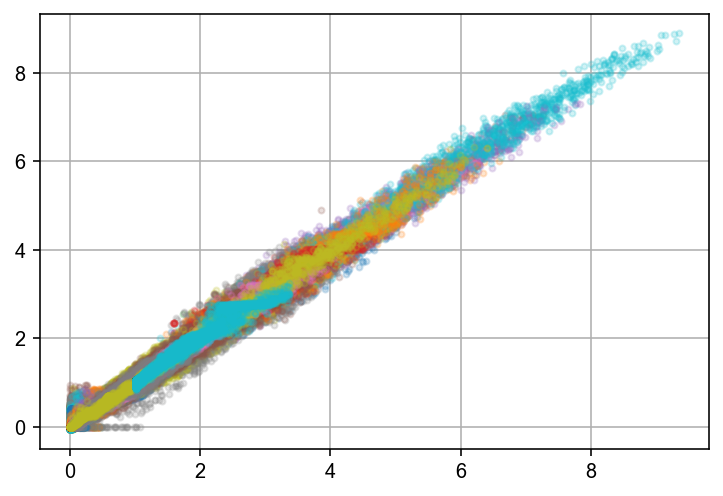

In [45]:
for c in range(output_cor.shape[1]):
    plt.plot(output_soft[:,c], output_cor[:,c], '.', alpha=0.2)

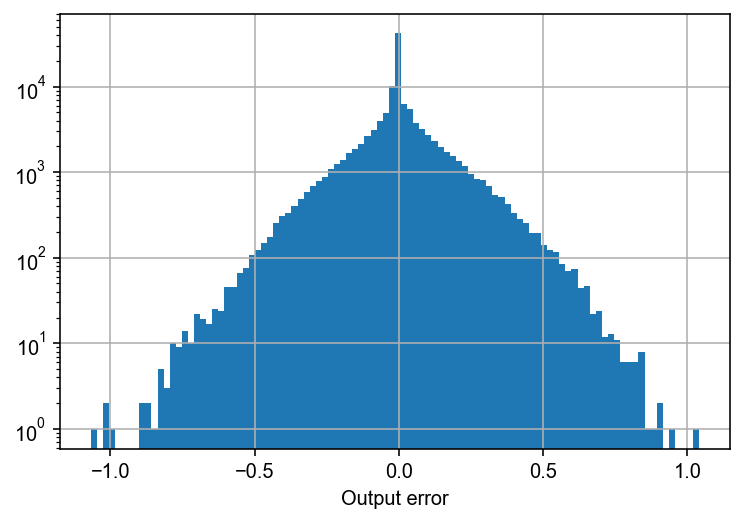

In [46]:
_ = plt.hist((output_cor - output_soft ).reshape(-1), 100)
plt.xlabel('Output error')

plt.yscale('log')

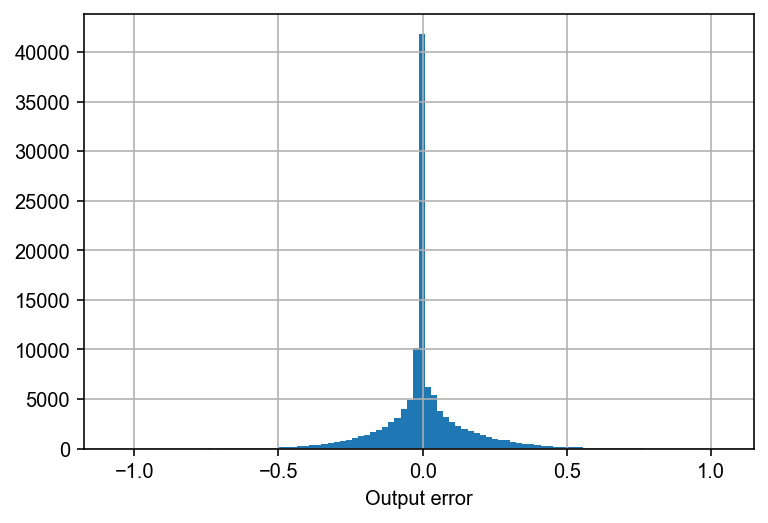

In [47]:
_ = plt.hist((output_cor - output_soft ).reshape(-1), 100)
plt.xlabel('Output error')

plt.yscale('linear')

In [48]:
def lin_cor_gains(output_gain, lin_cor_gain):
    output_cor = np.ones_like(output_gain[0]) * 0

    i = len(output_gain)
    for output in output_gain[::-1]:
        i -= 1

        output = output.copy()
        gain = gain_list[i]

        output[output > gain_th[gain] * th_rel[0]] = np.nan
        output[output < gain_th[gain] * th_rel[1]] = np.nan

        lin_cor = lin_cor_gain[i]

        for c in range(output.shape[1]):

            idx = np.isfinite(output[:,c]) 
            output_cor[idx,c] = output[idx,c] * lin_cor[c][0] + lin_cor[c][1]
            
    return output_cor

In [49]:
output_cor = lin_cor_gains(output_gain, lin_cor_gain)

c:\users\localuser\.venvs\py37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


## Plot the difference

In [50]:
from lib_ecc import *

delta = 0.15
Delta = 8 * delta

m = nn.Mconv.shape[0]
k = nn.Mconv.shape[1]

ecc = dpeECC(nn.Mconv, delta, Delta)

In [54]:
N_IMG = 10000

y1_raw_list = []
y1_ecc_list = []
y1_soft_list = []

i = 0

n_detected = 0
n_corrected = 0
n_other = 0

pbar = tqdm(zip(test_images[:N_IMG], test_labels[:N_IMG]), total=N_IMG)
y_preds = []

for img, lab in pbar:
    vectors = nn._conv_flattern(img)
    
    output_gain = []
    for gain in gain_list:
        output = dpe.multiply(
            1, 
            vectors, 
            c_sel=[cs, cs+G_conv_ecc.shape[1]], 
            r_start=rs, mode=0, Tdly=500, gain=gain
        ) / (nn.Gratio)
        
        output_gain.append(output)

    output = lin_cor_gains(output_gain, lin_cor_gain)
    y1 = output[:, ::2] - output[:, 1::2]
    
    output_soft = vectors.T @ G_conv_ecc / nn.Gratio
    y1_soft = output_soft[:, ::2] - output_soft[:, 1::2]
    
    y1_raw_list.append(y1.copy())
    y1_soft_list.append(y1_soft.copy())
    
    ##
    y1_corrected = correct_ecc(y1, ecc)

    y1_ecc_list.append( y1_corrected )
    
#     y1_ecc_list.append(y1.copy())
    k = nn.Gconv.shape[1] //2
    x = y1[:, :k]
    
    y_pred = dense(x, nn, finalGfc)
#     x = x.reshape(20, 20, -1)
#     x1 = nn.relu(x)
#     x1 = nn.max_pooling(x1)
#     x1 = nn.flattern(x1)
#     x1 = np.append(x1, 1)
#     y = x1.T @ finalGfc
#     y = y[::2] - y[1::2]
#     y_pred.append(y.argmax())
    i+=1

    y_preds.append(y_pred)
    pbar.set_description(f'Accuracy={np.mean(test_labels[:i] == np.array(y_preds))*100:.2f}%')
    
    if i%500 ==0:
        save_workspace(vars(), note='multi-gain-repeat-all')

[ERROR] SPI return wrong value
[ERROR] SPI return wrong value
[ERROR] SPI return wrong value


c:\users\localuser\.venvs\py37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in less
  if sys.path[0] == '':


Saving In(<class 'list'>), Out(<class 'dict'>), weights(<class 'numpy.ndarray'>), test_images(<class 'numpy.ndarray'>), test_labels(<class 'numpy.ndarray'>), g(<class 'numpy.ndarray'>), img_idx(<class 'int'>), image(<class 'numpy.ndarray'>), vectors(<class 'numpy.ndarray'>), outputs(<class 'numpy.ndarray'>), software(<class 'numpy.ndarray'>), c(<class 'int'>), x(<class 'numpy.ndarray'>), y(<class 'numpy.ndarray'>), mat_contents(<class 'dict'>), finalGconv(<class 'numpy.ndarray'>), g1(<class 'numpy.ndarray'>), g2(<class 'numpy.ndarray'>), linear_factors_conv(<class 'numpy.ndarray'>), acc(<class 'list'>), result(<class 'numpy.ndarray'>), x1(<class 'numpy.ndarray'>), new_lin_cor_fc1(<class 'list'>), new_lin_cor_fc2(<class 'list'>), lin_cor_conv(<class 'list'>), finalGfc(<class 'numpy.ndarray'>), delta(<class 'float'>), Delta(<class 'float'>), m(<class 'int'>), k(<class 'int'>), M_conv_ecc(<class 'numpy.ndarray'>), G_conv_ecc(<class 'numpy.ndarray'>), G_parity_ecc(<class 'numpy.ndarray'>),

In [55]:
save_workspace(vars(), note='multi-gain-repeat-97')

Saving In(<class 'list'>), Out(<class 'dict'>), weights(<class 'numpy.ndarray'>), test_images(<class 'numpy.ndarray'>), test_labels(<class 'numpy.ndarray'>), g(<class 'numpy.ndarray'>), img_idx(<class 'int'>), image(<class 'numpy.ndarray'>), vectors(<class 'numpy.ndarray'>), outputs(<class 'numpy.ndarray'>), software(<class 'numpy.ndarray'>), c(<class 'int'>), x(<class 'numpy.ndarray'>), y(<class 'numpy.ndarray'>), mat_contents(<class 'dict'>), finalGconv(<class 'numpy.ndarray'>), g1(<class 'numpy.ndarray'>), g2(<class 'numpy.ndarray'>), linear_factors_conv(<class 'numpy.ndarray'>), acc(<class 'list'>), result(<class 'numpy.ndarray'>), x1(<class 'numpy.ndarray'>), new_lin_cor_fc1(<class 'list'>), new_lin_cor_fc2(<class 'list'>), lin_cor_conv(<class 'list'>), finalGfc(<class 'numpy.ndarray'>), delta(<class 'float'>), Delta(<class 'float'>), m(<class 'int'>), k(<class 'int'>), M_conv_ecc(<class 'numpy.ndarray'>), G_conv_ecc(<class 'numpy.ndarray'>), G_parity_ecc(<class 'numpy.ndarray'>),

In [255]:
load_workspace(vars(), filename='20200623-230438-multi-gain-fitting-100')

Loaded: In, Out, weights, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, acc, result, x1, new_lin_cor_fc1, new_lin_cor_fc2, lin_cor_conv, finalGfc, delta, Delta, m, k, M_conv_ecc, G_conv_ecc, G_parity_ecc, rs, cs, i, N_IMG, vectors_list, output_list, img, output, output_soft, output_cor, gain_list, output_gain, gain, gain_th, gain_value, idx, lin_cor, lin_cor_gain, th_rel, y1_raw_list, y1_ecc_list, y1_soft_list, n_detected, n_corrected, n_other, y1, y1_soft, S, s, yy, ecc_loc, y_pred, y1_raw, y1_ecc, err_raw, err_ecc, 


In [ ]:
n_detected, n_corrected, n_other

In [57]:
y1_raw = np.array(y1_raw_list)
y1_soft = np.array(y1_soft_list)
y1_ecc = np.array(y1_ecc_list)

y1_raw.shape, y1_soft.shape, y1_ecc.shape

((2, 400, 15), (2, 400, 15), (2, 400, 15))

(-1.5, 1.5)

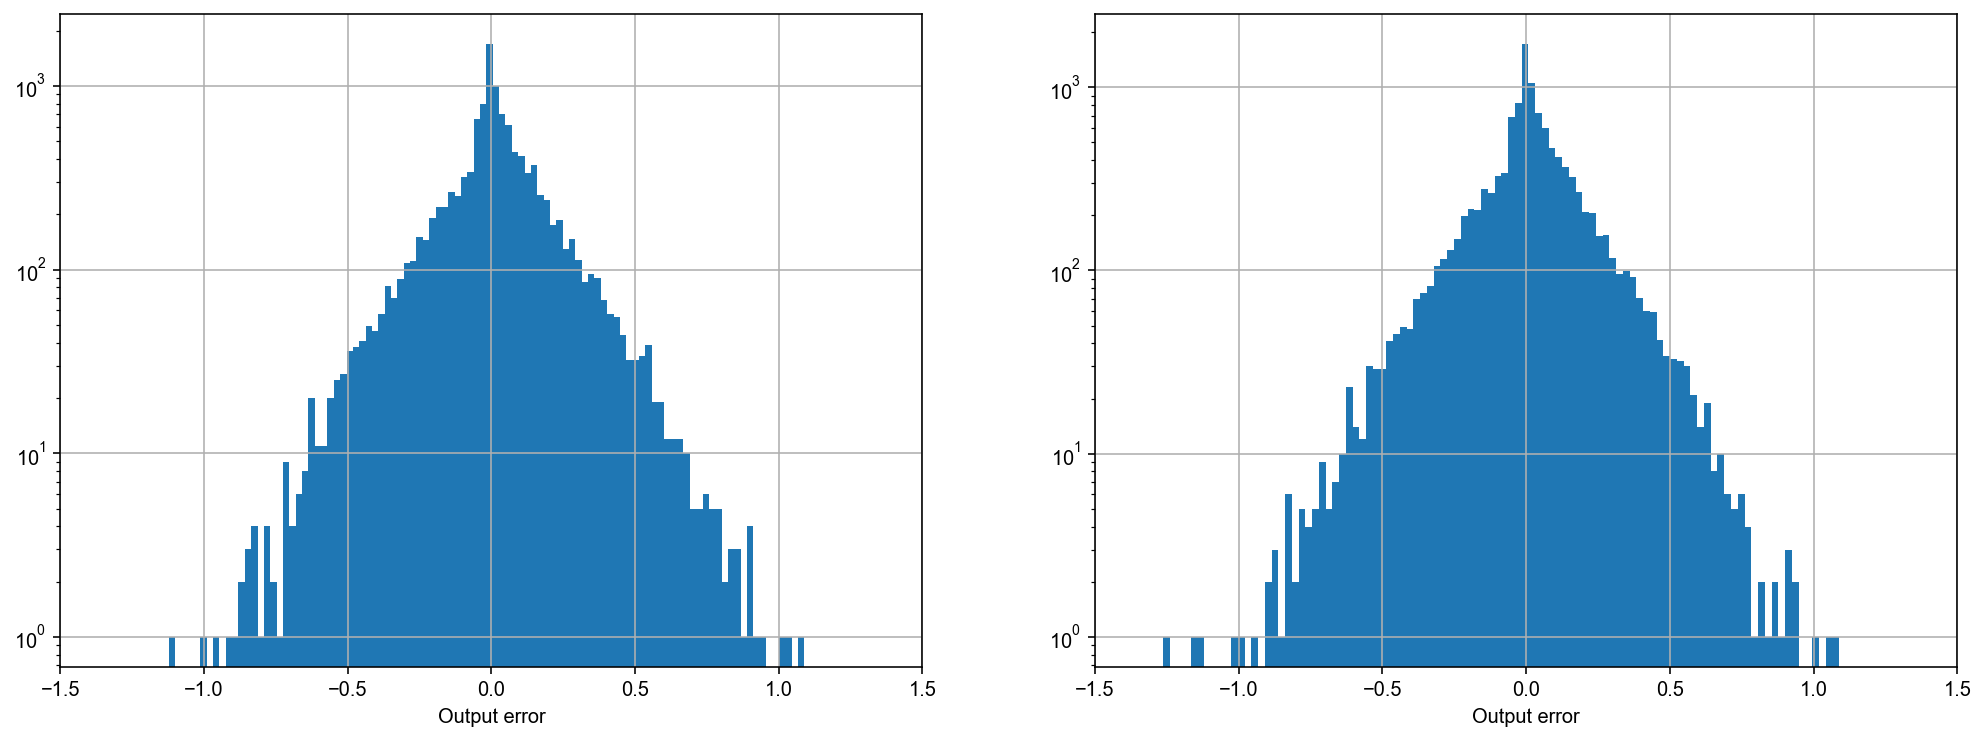

In [58]:
plt.figure(figsize=(17, 6))

plt.subplot(1,2,1)

_ = plt.hist((y1_raw - y1_soft ).reshape(-1), 100)
plt.xlabel('Output error')
plt.yscale('log')
plt.xlim((-1.5,1.5))

plt.subplot(1,2,2)
_ = plt.hist((y1_ecc - y1_soft ).reshape(-1), 100)
plt.xlabel('Output error')
plt.yscale('log')
plt.xlim((-1.5,1.5))

In [59]:
err_raw = (y1_raw - y1_soft).reshape(-1)

np.std(err_raw)

0.1981474547645706

In [60]:
err_ecc = (y1_ecc - y1_soft).reshape(-1)

np.std(err_ecc)

0.19879517516408154

Text(0, 0.5, 'Cummulative number of error')

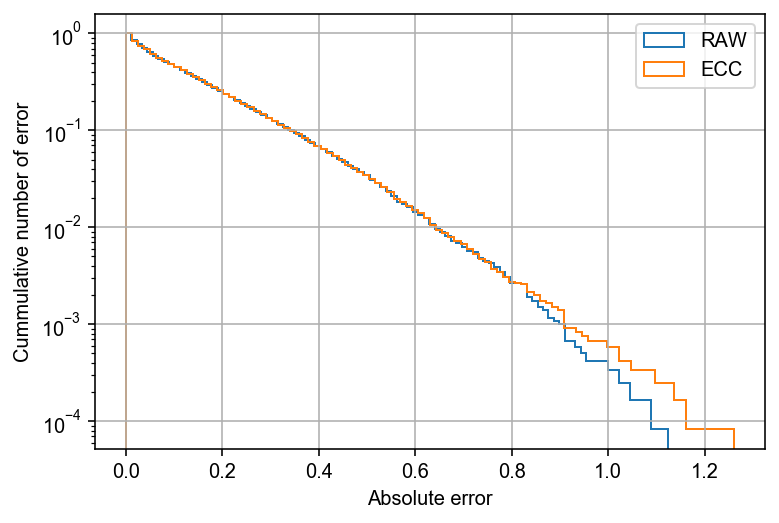

In [61]:
_ = plt.hist(abs(err_raw), density=True, histtype='step', cumulative=-1,
        label='RAW', bins=100)

_ = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
        label='ECC', bins=100)

plt.legend()

plt.yscale('log')

plt.xlabel('Absolute error')
plt.ylabel('Cummulative number of error')

## Explore delta

In [250]:
from lib_ecc import *

In [263]:
y1_raw = np.array(y1_raw_list).reshape(-1, 15)
y1_soft = np.array(y1_soft_list).reshape(-1, 15)
# y1_ecc = np.array(y1_ecc_list).reshape()

In [264]:
delta_list = np.arange(0.02, 0.5, 0.02)

y1_ecc_list_list = []

for delta in tqdm(delta_list):
    y1_ecc_list = []
    
    Delta = 8 * delta
    ecc = dpeECC(nn.Mconv, delta, Delta)

#     for y1_raw in y1_raw_list:
    y1_ecc_list.append( correct_ecc(y1_raw, ecc) )
        
    y1_ecc_list_list.append(y1_ecc_list)

In [ ]:
# output_soft = vectors.T @ G_conv_ecc / nn.Gratio
# y1_soft = output_soft[:, ::2] - output_soft[:, 1::2]

plt.figure(figsize=(17,20))

# for i in range(len(y1_list)):
for i in range(20):
    
    plt.subplot(5,4,i+1)

#     y1_raw = y1_raw_list[0]
    y1_ecc = y1_ecc_list_list[i]


    err_raw = (y1_raw - y1_soft).reshape(-1)
    err_ecc = (y1_ecc - y1_soft).reshape(-1)


    _ = plt.hist(abs(err_raw), density=True, histtype='step', cumulative=-1,
            label='RAW', bins=100)

    _ = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
            label='ECC', bins=100)

    plt.legend()

    plt.yscale('log')
    plt.xlabel('Absolute error')
    plt.ylabel('Cummulative number of error')
    
    plt.title(f'delta = {delta_list[i]:.2f}')
    
plt.tight_layout()